### https://github.com/Oldpan/Faceswap-Deepfake-Pytorch

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import cv2
from torch_snippets_local import *
from random_warp import get_training_data
import warnings
import configparser
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [2]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [3]:
def crop_face(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    if(len(faces)>0):
        for (x,y,w,h) in faces:
            img2 = img[y:(y+h),x:(x+w),:]
        img2 = cv2.resize(img2,(256,256))
        return img2, True
    else:
        return img, False

In [4]:
# 記得要建立兩個不同人臉的資料夾
#!mkdir cropped_faces_personA
#!mkdir cropped_faces_personB

In [5]:
def crop_images(folder):
    images = Glob(folder+'/*.jpg')
    folder_mapping = {'cage':'personA', 'trump':'personB'}
    print(f'{folder} has {len(images)} images')
    for i in range(len(images)):
        img = readImage2RGB(images[i])
        img2, face_detected = crop_face(img)
        if(face_detected==False):
            continue
        else:
            dest_folder = folder_mapping[folder.split('/')[-1]]
            cv2.imwrite('cropped_faces_'+dest_folder+'/'+str(i)+'.jpg',cv2.cvtColor(img2, cv2.COLOR_RGB2BGR))

# Load configuration
config = configparser.ConfigParser()
config.read('config.ini')
# Load parameters from config file
#root = '/Users/leonjye/Documents/MachineLearingData'
root = config.get('DEFAULT', 'root_dir')
IMAGE_ROOT = os.path.join(root, 'faceswap-pytorch', 'data')
crop_images(os.path.join(IMAGE_ROOT, 'cage'))
crop_images(os.path.join(IMAGE_ROOT, 'trump'))

/Users/leonjye/Documents/MachineLearingData/faceswap-pytorch/data/cage has 318 images
/Users/leonjye/Documents/MachineLearingData/faceswap-pytorch/data/trump has 376 images


In [6]:
from torch.utils.data import Dataset, DataLoader
class ImageDataset(Dataset):
    def __init__(self, items_A, items_B):
        self.items_A = np.concatenate([readImage2RGB(f)[None] for f in items_A])/255.
        self.items_B = np.concatenate([readImage2RGB(f)[None] for f in items_B])/255.
        self.items_A += self.items_B.mean(axis=(0, 1, 2)) - self.items_A.mean(axis=(0, 1, 2))

    def __len__(self):
        return min(len(self.items_A), len(self.items_B))
    def __getitem__(self, ix):
        a, b = choose(self.items_A), choose(self.items_B)
        return a, b

    def collate_fn(self, batch):
        imsA, imsB = list(zip(*batch))
        imsA, targetA = get_training_data(imsA, len(imsA))
        imsB, targetB = get_training_data(imsB, len(imsB))
        imsA, imsB, targetA, targetB = [torch.Tensor(i).permute(0,3,1,2).to(device) for i in [imsA, imsB, targetA, targetB]]
        return imsA, imsB, targetA, targetB

a = ImageDataset(Glob('cropped_faces_personA'), Glob('cropped_faces_personB'))
x = DataLoader(a, batch_size=32, collate_fn=a.collate_fn)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.046027415..0.8171546].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.016906282..0.9073196].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.05232846..0.7834888].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.022307396..0.7933502].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.051131096..0.83049625].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.003269454..0.98273116].


Tensor	Shape: torch.Size([32, 3, 64, 64])	Min: -0.052	Max: 0.984	Mean: 0.548	dtype: torch.float32 @ cpu
Tensor	Shape: torch.Size([32, 3, 64, 64])	Min: 0.000	Max: 1.000	Mean: 0.528	dtype: torch.float32 @ cpu
Tensor	Shape: torch.Size([32, 3, 64, 64])	Min: -0.051	Max: 0.984	Mean: 0.549	dtype: torch.float32 @ cpu
Tensor	Shape: torch.Size([32, 3, 64, 64])	Min: 0.000	Max: 1.000	Mean: 0.529	dtype: torch.float32 @ cpu


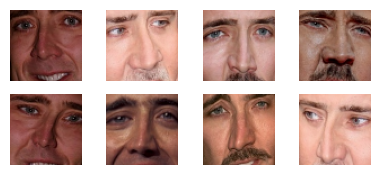

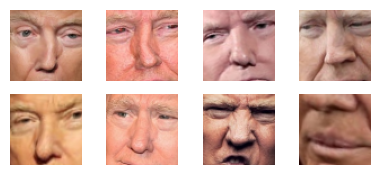

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.043460295..0.8339683].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.011825895..0.93997324].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.052324843..0.7912046].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.028661545..0.73821604].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04871147..0.8221745].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0016750937..0.95370394].


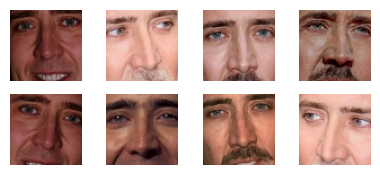

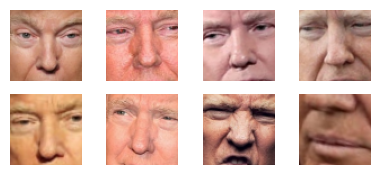

In [8]:
inspect_shape(*next(iter(x)))

for i in next(iter(x)):
    subplots(i[:8], nc=4, sz=(4,2))

In [9]:
def _ConvLayer(input_features, output_features):
    return nn.Sequential(
        nn.Conv2d(input_features, output_features, kernel_size=5, stride=2, padding=2),
        nn.LeakyReLU(0.1, inplace=True)
    )

def _UpScale(input_features, output_features):
    return nn.Sequential(
        nn.ConvTranspose2d(input_features, output_features, kernel_size=2, stride=2, padding=0),
        nn.LeakyReLU(0.1, inplace=True)
    )

class Reshape(nn.Module):
    def forward(self, input):
        output = input.view(-1, 1024, 4, 4) # channel * 4 * 4
        return output

In [10]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            _ConvLayer(3, 128),
            _ConvLayer(128, 256),
            _ConvLayer(256, 512),
            _ConvLayer(512, 1024),
            nn.Flatten(),
            nn.Linear(1024 * 4 * 4, 1024),
            nn.Linear(1024, 1024 * 4 * 4),
            Reshape(),
            _UpScale(1024, 512),
        )

        self.decoder_A = nn.Sequential(
            _UpScale(512, 256),
            _UpScale(256, 128),
            _UpScale(128, 64),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Sigmoid(),
        )

        self.decoder_B = nn.Sequential(
            _UpScale(512, 256),
            _UpScale(256, 128),
            _UpScale(128, 64),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x, select='A'):
        if select == 'A':
            out = self.encoder(x)
            out = self.decoder_A(out)
        else:
            out = self.encoder(x)
            out = self.decoder_B(out)
        return out

In [12]:
from torchsummary import summary
model = Autoencoder()
summary(model, input_size=(3, 64, 64), device=device.type) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 32, 32]           9,728
         LeakyReLU-2          [-1, 128, 32, 32]               0
            Conv2d-3          [-1, 256, 16, 16]         819,456
         LeakyReLU-4          [-1, 256, 16, 16]               0
            Conv2d-5            [-1, 512, 8, 8]       3,277,312
         LeakyReLU-6            [-1, 512, 8, 8]               0
            Conv2d-7           [-1, 1024, 4, 4]      13,108,224
         LeakyReLU-8           [-1, 1024, 4, 4]               0
           Flatten-9                [-1, 16384]               0
           Linear-10                 [-1, 1024]      16,778,240
           Linear-11                [-1, 16384]      16,793,600
          Reshape-12           [-1, 1024, 4, 4]               0
  ConvTranspose2d-13            [-1, 512, 8, 8]       2,097,664
        LeakyReLU-14            [-1, 51

In [13]:
def train_batch(model, data, criterion, optimizers):
    optA, optB = optimizers
    optA.zero_grad()
    optB.zero_grad()
    imgA, imgB, targetA, targetB = data
    _imgA, _imgB = model(imgA, 'A'), model(imgB, 'B')

    lossA = criterion(_imgA, targetA)
    lossB = criterion(_imgB, targetB)
    
    lossA.backward()
    lossB.backward()

    optA.step()
    optB.step()

    return lossA.item(), lossB.item()

In [14]:
model = Autoencoder().to(device)

dataset = ImageDataset(Glob('cropped_faces_personA'), Glob('cropped_faces_personB'))
dataloader = DataLoader(dataset, 32, collate_fn=dataset.collate_fn)

optimizers = optim.Adam([{'params': model.encoder.parameters()},
                          {'params': model.decoder_A.parameters()}],
                        lr=5e-5, betas=(0.5, 0.999)), \
             optim.Adam([{'params': model.encoder.parameters()},
                          {'params': model.decoder_B.parameters()}], 
                        lr=5e-5, betas=(0.5, 0.999))
             
criterion = nn.L1Loss()

In [15]:
#!mkdir checkpoint

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.032167923..0.9617309].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.051638793..0.9779279].


══════════════════════════════A TO B══════════════════════════════


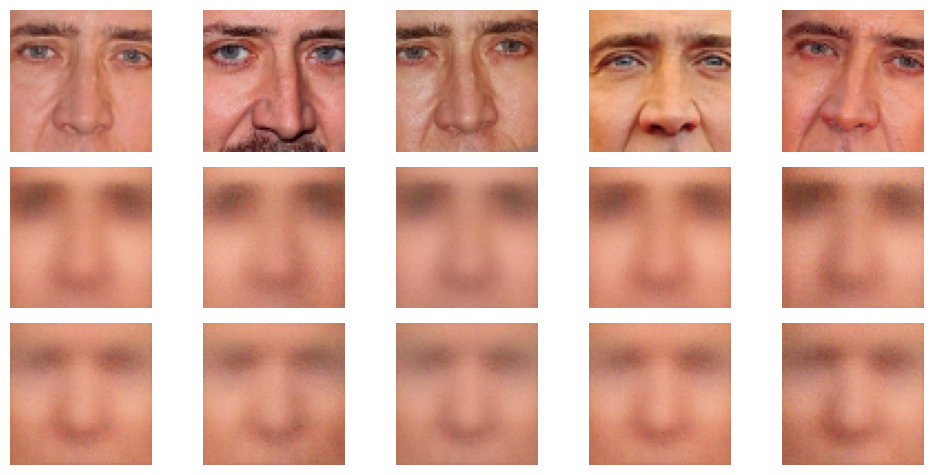

══════════════════════════════B TO A══════════════════════════════


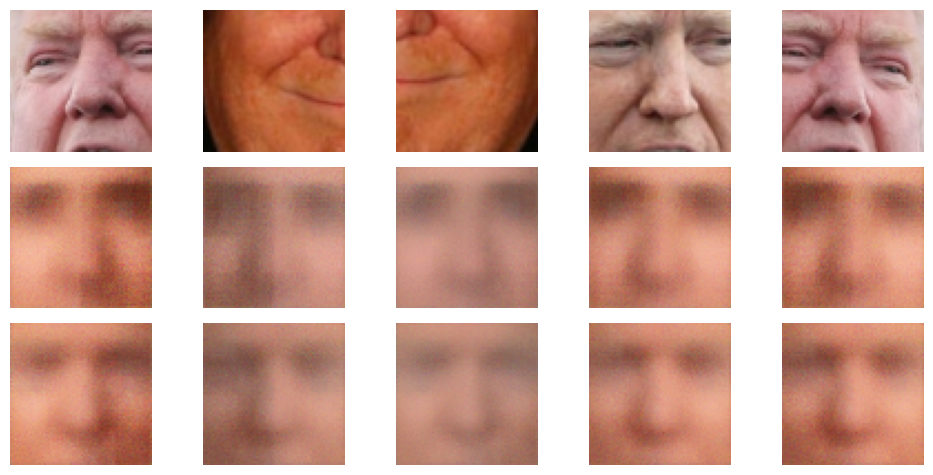

In [ ]:
n_epochs = 10000
#log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(dataloader)
    for bx,data in enumerate(dataloader):
        lossA, lossB = train_batch(model, data, criterion, optimizers)
        if (bx+1)%10 == 0:
            print(f'[{ex+1}/{n_epochs}] [{bx+1}/{N}] LossA: {lossA:.4f} LossB: {lossB:.4f}')
        #log.record(ex+(1+bx)/N, lossA=lossA, lossB=lossB, end='\r')

    #log.report_avgs(ex+1)
    if (ex+1)%100 == 0:
        state = {
                'state': model.state_dict(),
                'epoch': ex
            }
        torch.save(state, './checkpoint/autoencoder.pth')

    if (ex+1)%100 == 0:
        bs = 5
        a,b,A,B = data
        line('A to B')
        _a = model(a[:bs], 'A')
        _b = model(a[:bs], 'B')
        x = torch.cat([A[:bs],_a,_b])
        subplots(x, nc=bs, figsize=(bs*2, 5))

        line('B to A')
        _a = model(b[:bs], 'A')
        _b = model(b[:bs], 'B')
        x = torch.cat([B[:bs],_a,_b])
        subplots(x, nc=bs, figsize=(bs*2, 5))

#log.plot_epochs()